In [1]:
# get all imports out of the way
import tensorneat as tn
import jax.numpy as jnp
import pandas as pd

In [39]:
# get all the symbols we can pull live data for
import os

# Path to the directory
directory_path = "hist_data/stocks/single"

# List all files in the directory
files = os.listdir(directory_path)

live_syms = [file.split('_')[0] for file in files]

# drop nans split by symbol and join on date
file_path = "hist_data/stocks/sp500_stocks.csv"  # Update this path if needed
df = pd.read_csv(file_path)

df = df.dropna()

symbols = df['Symbol'].unique()
symbol_dfs = {symbol: df[df['Symbol'] == symbol] for symbol in symbols}

merged_df = symbol_dfs[symbols[0]].set_index('Date')

for symbol in symbols[1:]:
    symbol_data = symbol_dfs[symbol].set_index('Date')
    if (len(symbol_data) == 3768 and symbol in live_syms):
        merged_df = merged_df.join(symbol_data, how='inner', rsuffix=f"_{symbol}")

tensorneat_input = merged_df.to_numpy()

print(tensorneat_input.shape)

(3768, 1029)


In [202]:
print(merged_df.head())

           Symbol  Adj Close     Close      High       Low      Open  \
Date                                                                   
2010-01-04    AOS   5.937266  7.435000  7.480000  7.261667  7.295000   
2010-01-05    AOS   5.861404  7.340000  7.431667  7.308333  7.431667   
2010-01-06    AOS   5.864068  7.343333  7.405000  7.301667  7.335000   
2010-01-07    AOS   5.881369  7.365000  7.425000  7.311667  7.356667   
2010-01-08    AOS   5.967879  7.473333  7.485000  7.311667  7.331667   

               Volume Symbol_ABT  Adj Close_ABT  Close_ABT  ...    Low_WMB  \
Date                                                        ...              
2010-01-04  1104600.0        ABT      18.763718  26.129908  ...  17.445280   
2010-01-05  1207200.0        ABT      18.612118  25.918797  ...  17.534952   
2010-01-06   663000.0        ABT      18.715481  26.062737  ...  17.771360   
2010-01-07   564000.0        ABT      18.870522  26.278646  ...  18.072985   
2010-01-08   504600.0      

In [40]:
# create a target array

close_columns = [col for col in merged_df.columns if col.split('_')[0] == 'Close']
open_columns = [col for col in merged_df.columns if col.split('_')[0] == 'Open']
# features and target prep
'''
feature_df = merged_df[close_columns].copy()
for c in close_columns:
    feature_df[f'{c}_ma5'] = feature_df[c].rolling(window=5).mean()
    feature_df[f'{c}_ma10'] = feature_df[c].rolling(window=10).mean()
    feature_df[f'{c}_ma20'] = feature_df[c].rolling(window=20).mean()
    feature_df[f'{c}_avg_change_13'] = feature_df[c].pct_change().rolling(window=13).mean()
    feature_df[f'{c}_stddev_13'] = feature_df[c].pct_change().rolling(window=13).std()
print(feature_df.values.shape)
'''

# shift target and adjust features accordingly
target = merged_df[open_columns].pct_change().shift(-1).values[:-2,:]
features = merged_df[open_columns].pct_change().values
print(target.shape)

print(features.shape)

(3766, 147)
(3768, 147)


In [41]:
import jax.numpy as jnp
train_test_split = 0.9

sample_count = target.shape[0]
print(f"Sample Count: {sample_count}")
train_size = int(sample_count * train_test_split)
print(f"Train Size: {train_size}")
TEST_INPUTS = features[train_size:, :]
TEST_RETURNS = target[train_size:, :]
INPUTS = features[:train_size, :]
RETURNS = target[:train_size, :]

print(f"Shape of INPUTS: {INPUTS.shape}")
print(f"Shape of RETURNS: {RETURNS.shape}")


Sample Count: 3766
Train Size: 3389
Shape of INPUTS: (3389, 147)
Shape of RETURNS: (3389, 147)


In [42]:
import jax, jax.numpy as jnp
from tensorneat.problem.base import BaseProblem
import tensorneat.algorithm.neat as neat_algorithm
import matplotlib.pyplot as plt
import random
EPISODE_LEN = 34

class TradingProblem(BaseProblem):
  jitable = True
  episode_len = EPISODE_LEN
  pop_size = 100
  
  def __init__(self):
      super().__init__()
      self.pop_counter = 0
      self.start_idx = random.randint(0, INPUTS.shape[0] - self.episode_len)
      self.end_idx = self.start_idx + self.episode_len

  @property
  def input_shape(self):
    return (INPUTS.shape[1],)

  @property
  def output_shape(self):
    return (1,)

  def evaluate(self, state, randkey, act_func, params):
      # Get the network's outputs for all inputs
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, INPUTS)
      
      # Find the index of the maximum output for each day
      selected_indices = jnp.argmax(actions, axis=1)
      
      # Calculate the reward based on the selected index
      reward = jnp.take_along_axis(RETURNS, selected_indices[:, None], axis=1).squeeze()
      
      # Return the mean reward
      return jnp.mean(reward)

  def show(self, state, randkey, act_func, params, *args, **kwargs):
      # Get actions as a host numpy array
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, TEST_INPUTS)
      selected_indices = jnp.argmax(actions, axis=1)

      # Move data to host numpy
      from jax import device_get
      import numpy as np
      selected_indices_np = np.asarray(device_get(selected_indices)).ravel()
      returns_np = np.asarray(device_get(TEST_RETURNS))

      # Ensure indices are within bounds
      num_columns = returns_np.shape[1]
      selected_indices_np = np.clip(selected_indices_np, 0, num_columns - 1)

      # Calculate performance based on selected indices
      perf = 100.0
      perf_hist = []
      last_pick = live_syms[selected_indices_np[-1]]
      print("Last selected symbol:", last_pick)
      for i in range(len(selected_indices_np)-1):
          selected_return = returns_np[i, selected_indices_np[i]]
          perf += perf * float(selected_return)
          perf_hist.append(float(perf))

      # Plot using numpy list of floats
      import matplotlib.pyplot as plt
      plt.plot(perf_hist)
      print("Initial performance:", perf_hist[0])
      print("Final performance:", perf_hist[-1])
      plt.show()

# Assuming INPUTS and RETURNS are defined from previous cells
trading_problem = TradingProblem()



In [58]:
import jax, jax.numpy as jnp
from tensorneat.problem.base import BaseProblem
import tensorneat.algorithm.neat as neat_algorithm
import matplotlib.pyplot as plt
import random
EPISODE_LEN = 34

class TradingProblemTopK(BaseProblem):
  jitable = True
  episode_len = EPISODE_LEN
  pop_size = 100
  
  def __init__(self):
      super().__init__()
      self.pop_counter = 0
      self.start_idx = random.randint(0, INPUTS.shape[0] - self.episode_len)
      self.end_idx = self.start_idx + self.episode_len

  @property
  def input_shape(self):
    return (INPUTS.shape[1],)

  @property
  def output_shape(self):
    return (1,)

  def evaluate(self, state, randkey, act_func, params, k=3):
      # Get the network's outputs for all inputs
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, INPUTS)

      # Get the top-k values and indices
      topk_values, topk_indices = jax.lax.top_k(actions, k)

      # Apply softmax to the top-k values to get weights
      softmax_weights = jax.nn.softmax(topk_values, axis=1)

      # Gather the rewards for the top-k indices
      rewards = jnp.take_along_axis(RETURNS, topk_indices, axis=1)

      # Calculate the weighted reward
      weighted_rewards = jnp.sum(rewards, axis=1)
      return jnp.mean(weighted_rewards)

  def show(self, state, randkey, act_func, params, k=3, *args, **kwargs):
      # Get actions as a host numpy array
      actions = jax.vmap(act_func, in_axes=(None, None, 0))(state, params, TEST_INPUTS)
      
      # Get the top-k values and indices
      topk_values, topk_indices = jax.lax.top_k(actions, k)
      
      # Apply softmax to the top-k values to get weights
      softmax_weights = jax.nn.softmax(topk_values, axis=1)
      
      # Move data to host numpy
      from jax import device_get
      import numpy as np
      topk_indices_np = np.asarray(device_get(topk_indices))
      softmax_weights_np = np.asarray(device_get(topk_values))
      returns_np = np.asarray(device_get(TEST_RETURNS))
      
      # Calculate performance based on top-k weighted rewards
      perf = 100.0
      perf_hist = []
      todays_syms = [live_syms[i] for i in topk_indices_np[-1]]
      print("Today's selected symbols:", todays_syms)
      for i in range(len(topk_indices_np)-2):
          # Gather the rewards for the top-k indices
          rewards = returns_np[i, topk_indices_np[i]]
          
          # Calculate the weighted reward
          weighted_reward = np.mean(rewards)
          
          # Update performance
          perf += perf * float(weighted_reward)
          perf_hist.append(float(perf))
      
      # Plot using numpy list of floats
      import matplotlib.pyplot as plt
      plt.plot(perf_hist)
      print("Initial performance:", perf_hist[0])
      print("Final performance:", perf_hist[-1])
      plt.show()

  def show_averaged(self, state, randkey, act_func, params_list, k=3, *args, **kwargs):
      """
      Show the averaged performance of multiple networks.
      
      Args:
          state: The state of the problem.
          randkey: Random key for JAX operations.
          act_func: Activation function for the networks.
          params_list: List of network parameters (one for each network).
          k: Number of top-k actions to consider.
      """
      import numpy as np
      from jax import device_get
      import matplotlib.pyplot as plt

      # Initialize performance tracking
      perf = 100.0
      perf_hist = []

      # Iterate over the test inputs
      for i in range(TEST_INPUTS.shape[0]):
          # Collect actions from all networks
          actions_list = [
              jax.vmap(act_func, in_axes=(None, None, 0))(state, params, TEST_INPUTS[i:i+1, :])
              for params in params_list
          ]

          # Average the actions across all networks
          avg_actions = jnp.mean(jnp.stack(actions_list, axis=0), axis=0)

          # Get the top-k values and indices
          topk_values, topk_indices = jax.lax.top_k(avg_actions, k)

          # Apply softmax to the top-k values to get weights
          softmax_weights = jax.nn.softmax(topk_values, axis=1)

          # Move data to host numpy
          topk_indices_np = np.asarray(device_get(topk_indices))
          softmax_weights_np = np.asarray(device_get(softmax_weights))
          returns_np = np.asarray(device_get(TEST_RETURNS))

          # Gather the rewards for the top-k indices
          rewards = returns_np[i, topk_indices_np[0]]
          weighted_reward = np.sum(softmax_weights_np[0] * rewards)

          # Update performance
          perf += perf * float(weighted_reward)
          perf_hist.append(float(perf))

      # Plot the performance history
      plt.plot(perf_hist)
      print("Initial performance:", perf_hist[0])
      print("Final performance:", perf_hist[-1])
      plt.show()

# Assuming INPUTS and RETURNS are defined from previous cells
trading_problem = TradingProblemTopK()



In [ ]:
from tensorneat.pipeline import Pipeline
from tensorneat.algorithm.neat import NEAT
from tensorneat.genome import RecurrentGenome, BiasNode, DefaultConn,
from tensorneat.problem.func_fit import CustomFuncFit
from tensorneat.common import ACT, AGG
from tensorneat import algorithm

# Construct the pipeline and run
pipeline = Pipeline(
    algorithm=NEAT(
        pop_size=144,
        species_size=10,
        survival_threshold=0.1,
        compatibility_threshold=0.8,
        genome=RecurrentGenome(
            max_nodes=500,
            max_conns=1500,
            num_inputs=features.shape[1],
            num_outputs=target.shape[1],
            init_hidden_layers=(1,),
            node_gene=BiasNode(
                bias_init_std=0.1,
                bias_mutate_power=0.05,
                bias_mutate_rate=0.01,
                bias_replace_rate=0.0,
                activation_options=ACT.tanh,
                aggregation_options=AGG.sum,
            ),
            conn_gene=DefaultConn(
                weight_init_mean=0.0,
                weight_init_std=0.1,
                weight_mutate_power=0.05,
                weight_replace_rate=0.0,
                weight_mutate_rate=0.001,
            ),
            output_transform=ACT.tanh,
        ),
    ),
    problem=TradingProblemTopK(),
    generation_limit=610,
    fitness_target=.1,
    seed=42,
    is_save=True,
    save_dir="./model_archive/tensorneat_checkpoints"
)

# initialize state
state = pipeline.setup()
# run until terminate
state, best = pipeline.auto_run(state)
# show result
pipeline.show(state, best)
state.save("./model_archive/tensorneat_checkpoints/evolving_state.pkl")

save to ./model_archive/tensorneat_checkpoints
initializing
initializing finished
start compile


KeyboardInterrupt: 

In [45]:
sym_columns = [col for col in merged_df.columns if 'Symbol' in col]
sym_list = merged_df[sym_columns].iloc[0].values
print(sym_list)

['AOS' 'ABT' 'AES' 'ALB' 'ALL' 'GOOG' 'MO' 'AMZN' 'AXP' 'AMP' 'APH' 'ADM'
 'AJG' 'T' 'AXON' 'BKR' 'BAX' 'BDX' 'BBY' 'BK' 'BWA' 'BSX' 'BRO' 'BLDR'
 'COF' 'KMX' 'CCL' 'CAT' 'CE' 'CVX' 'CSCO' 'C' 'CLX' 'CME' 'CMCSA' 'ED'
 'STZ' 'GLW' 'CSGP' 'DE' 'DXCM' 'DLR' 'DG' 'DPZ' 'DOV' 'DHI' 'DTE' 'EMN'
 'EIX' 'EA' 'EQT' 'EFX' 'EQIX' 'EQR' 'ESS' 'EL' 'EXPE' 'FFIV' 'FDS' 'FAST'
 'FRT' 'FDX' 'FSLR' 'FTNT' 'BEN' 'FCX' 'GIS' 'GPN' 'HIG' 'HSIC' 'HRL'
 'HST' 'IEX' 'INCY' 'PODD' 'ICE' 'IFF' 'IP' 'ISRG' 'IRM' 'JBHT' 'JCI' 'K'
 'KIM' 'LH' 'LRCX' 'LEN' 'LKQ' 'MCD' 'MRK' 'MTD' 'MSFT' 'MSI' 'NDAQ'
 'NTAP' 'NFLX' 'NVDA' 'OMC' 'ON' 'ORCL' 'PKG' 'PH' 'PAYX' 'PEP' 'PM' 'PNW'
 'PNC' 'PPG' 'PPL' 'PFG' 'PGR' 'PEG' 'PHM' 'PWR' 'RJF' 'RTX' 'O' 'RF'
 'RVTY' 'CRM' 'SHW' 'SO' 'SWK' 'SBUX' 'TTWO' 'TJX' 'TT' 'TDG' 'TSN' 'USB'
 'UDR' 'UAL' 'UPS' 'UHS' 'VLO' 'VRSK' 'VRTX' 'VTRS' 'V' 'WRB' 'DIS' 'WEC'
 'WELL' 'WST' 'WDC' 'WMB' 'WTW']


In [46]:
live_dfs = {}
for sym in live_syms:
    sym_df = pd.read_csv(f"hist_data/stocks/single/{sym}_history.csv")
    sym_df["Symbol"] = sym
    live_dfs[sym] = sym_df.set_index('Date')
live_merged_df = live_dfs[live_syms[0]]
for sym in live_syms[1:]:
    symbol_data = live_dfs[sym].reindex(live_merged_df.index, fill_value=1)
    live_merged_df = live_merged_df.join(symbol_data, on='Date', how='outer', rsuffix=f"_{sym}")

print(len(live_merged_df))

287


In [47]:
# create a target array

close_columns = [col for col in live_merged_df.columns if col.split('_')[0] == 'Close']
open_columns = [col for col in live_merged_df.columns if col.split('_')[0] == 'Open']
# features and target prep
'''
feature_df = merged_df[close_columns].copy()
for c in close_columns:
    feature_df[f'{c}_ma5'] = feature_df[c].rolling(window=5).mean()
    feature_df[f'{c}_ma10'] = feature_df[c].rolling(window=10).mean()
    feature_df[f'{c}_ma20'] = feature_df[c].rolling(window=20).mean()
    feature_df[f'{c}_avg_change_13'] = feature_df[c].pct_change().rolling(window=13).mean()
    feature_df[f'{c}_stddev_13'] = feature_df[c].pct_change().rolling(window=13).std()
print(feature_df.values.shape)
'''

# shift target and adjust features accordingly
target = live_merged_df[open_columns].pct_change().shift(-1).values[:-2,:]
features = live_merged_df[open_columns].pct_change().values
print(target.shape)

print(features.shape)

(285, 147)
(287, 147)


In [48]:
import jax.numpy as jnp
train_test_split = 0.8

sample_count = target.shape[0]
print(f"Sample Count: {sample_count}")
train_size = int(sample_count * train_test_split)
print(f"Train Size: {train_size}")
TEST_INPUTS = features[train_size:, :]
TEST_RETURNS = target[train_size:, :]
INPUTS = features[:train_size, :]
RETURNS = target[:train_size, :]

print(f"Shape of INPUTS: {INPUTS.shape}")
print(f"Shape of RETURNS: {RETURNS.shape}")

Sample Count: 285
Train Size: 228
Shape of INPUTS: (228, 147)
Shape of RETURNS: (228, 147)


initializing
initializing finished
(500, 4) (1500, 3)
Today's selected symbols: ['EA', 'DPZ', 'NVDA']
Initial performance: 99.26021346159511
Final performance: 109.20986061903344


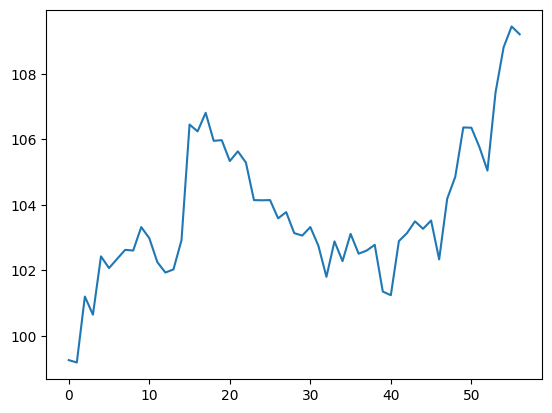

In [67]:
# for testing lasted genome from genomes checkpoints
import numpy as np
state = pipeline.setup()
best_path = "./model_archive/tensorneat_checkpoints/champs_topk/72.npz"
best_genome = np.load(best_path)
nodes = best_genome['nodes']
conns = best_genome['conns']
nodes_j = jnp.array(nodes)
conns_j = jnp.array(conns)
print(nodes.shape, conns.shape) 
# show result
pipeline.show(state, (nodes_j, conns_j))

initializing
initializing finished
(500, 4) (1500, 3)
Today's selected symbols: ['WDC', 'LRCX', 'AMZN']
Initial performance: 104.15390926475462
Final performance: 46.67080686128307


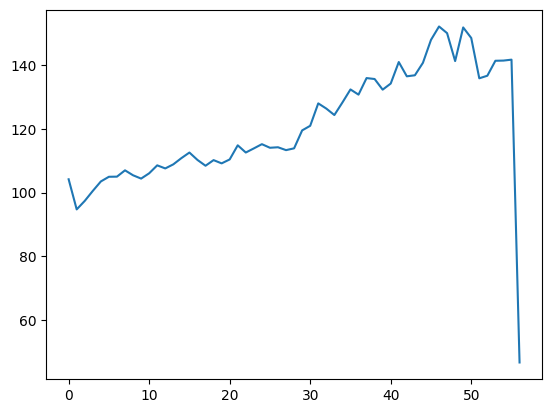

In [60]:
import numpy as np
topk_champs = os.listdir("./model_archive/tensorneat_checkpoints/champs_topk/")
state = pipeline.setup()
best_path = "./model_archive/tensorneat_checkpoints/genomes/2.npz"
best_genome = np.load(best_path)
nodes = best_genome['nodes']
conns = best_genome['conns']
nodes_j = jnp.array(nodes)
conns_j = jnp.array(conns)
print(nodes.shape, conns.shape) 
# show result
pipeline.show(state, (nodes_j, conns_j))

In [38]:
import yfinance as yf
import pandas as pd
import os

# Get the last date in merged_df
last_date = merged_df.index.max()
print(f"Last date in merged_df: {last_date}")


# Fetch historical data for all symbols in live_syms
for symbol in live_syms:
    print(f"Fetching data for {symbol}...")
    # Fetch data from the last date until now
    symbol_history = yf.download(symbol, start=last_date, progress=False)
    symbol_history.reset_index(inplace=True)
    symbol_history.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]
    print(symbol_history.head())
    # Save the data to a CSV file
    output_path = f"hist_data/stocks/single/{symbol}_history.csv"
    symbol_history.to_csv(output_path, index=False)
    print(f"Saved {symbol} data to {output_path}")

Last date in merged_df: 2024-12-20
Fetching data for ABT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  111.540771  112.400052  109.871022  109.988200  12311900
1 2024-12-23  111.618889  111.814185  110.300672  111.316189   4028200
2 2024-12-24  112.058296  112.126648  110.915835  111.452890   1480000
3 2024-12-26  112.556282  113.083570  111.140421  111.511473   2960500
4 2024-12-27  112.282875  113.220274  111.814180  112.302408   2829500
Saved ABT data to hist_data/stocks/single/ABT_history.csv
Fetching data for ADM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  48.593876  49.055849  47.400442  47.544810  12132700
1 2024-12-23  48.516880  48.632372  47.766174  48.122278   2592200
2 2024-12-24  48.728619  48.795990  48.103028  48.516879   1434600
3 2024-12-26  48.709370  48.978853  48.391761  48.459132   1627600
4 2024-12-27  48.680496  49.267585  48.285890  48.391760   1537700
Saved ADM data to hist_data/stocks/single/ADM_history.csv
Fetching data for AES...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  12.104465  12.206887  11.508552  11.508552  25105700
1 2024-12-23  12.160331  12.188264  11.899619  12.002042  10108300
2 2024-12-24  12.123086  12.151019  11.992730  12.104463   3967400
3 2024-12-26  11.955485  12.095152  11.880996  12.067219   7272100
4 2024-12-27  11.871685  11.946174  11.713396  11.871685   9280700
Saved AES data to hist_data/stocks/single/AES_history.csv
Fetching data for AJG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  280.642944  283.953952  274.585958  277.093999  2774900
1 2024-12-23  282.040680  282.506602  278.382704  279.225333  1935200
2 2024-12-24  285.847382  285.996074  281.108869  282.744542  1045800
3 2024-12-26  285.857239  286.610652  283.696167  284.062951  1173300
4 2024-12-27  284.053070  286.491711  282.724704  285.341775  7622800
Saved AJG data to hist_data/stocks/single/AJG_history.csv
Fetching data for ALB...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  86.847916  88.699495  85.740882  86.083773  3685400
1 2024-12-23  87.386734  88.033321  86.318895  87.220192  2003000
2 2024-12-24  88.160683  88.307635  86.191547  87.621868   595100
3 2024-12-26  87.337761  88.591740  86.661785  87.690443  1194900
4 2024-12-27  86.495239  89.003197  85.525366  86.838123  1397000
Saved ALB data to hist_data/stocks/single/ALB_history.csv
Fetching data for ALL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  189.833862  191.167682  183.802259  184.802613  2351800
1 2024-12-23  189.902512  190.108461  188.009657  188.843300  1336100
2 2024-12-24  191.756119  192.050347  189.206164  190.137873   453200
3 2024-12-26  191.854202  192.148430  190.775387  191.697294   563300
4 2024-12-27  190.069244  192.020926  188.882531  190.422315  1094400
Saved ALL data to hist_data/stocks/single/ALL_history.csv
Fetching data for AMP...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  523.841675  527.228160  512.943886  513.140787  1498700
1 2024-12-23  525.918823  526.096016  520.238630  521.547895   427100
2 2024-12-24  530.398071  531.490788  524.648899  528.527606   145100
3 2024-12-26  533.951904  534.572108  528.389779  528.389779   213700
4 2024-12-27  527.612000  535.359558  525.889225  532.032137   308300
Saved AMP data to hist_data/stocks/single/AMP_history.csv
Fetching data for AMZN...
        Date       Close        High         Low        Open    Volume
0 2024-12-20  224.919998  226.210007  218.729996  219.839996  88279200
1 2024-12-23  225.059998  226.880005  223.899994  225.009995  28070000
2 2024-12-24  229.050003  229.139999  226.130005  226.940002  15007500
3 2024-12-26  227.050003  228.500000  226.669998  228.500000  16146700
4 2024-12-27  223.750000  226.029999  220.899994  225.600006  27367100
Saved AMZN data to hist_data/stocks/single/AMZN_history.csv
Fetching d

C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  67.002792  67.675553  66.369033  66.534784  2859700
1 2024-12-23  66.846786  66.963791  66.398282  66.515286   574400
2 2024-12-24  67.168541  67.168541  66.447035  66.768790   381800
3 2024-12-26  67.168541  67.509793  66.759038  66.924788   670600
4 2024-12-27  66.720039  67.344046  66.525040  66.885790   517900
Saved AOS data to hist_data/stocks/single/AOS_history.csv
Fetching data for APH...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  70.040947  70.636363  68.423391  68.780642  12193100
1 2024-12-23  70.447807  70.656203  69.574531  70.249338   2970600
2 2024-12-24  71.112701  71.172241  70.269187  70.467664   1660900
3 2024-12-26  71.013451  71.251623  70.537121  70.705821   2882700
4 2024-12-27  70.199722  70.884455  69.733311  70.457739   4072300
Saved APH data to hist_data/stocks/single/APH_history.csv
Fetching data for AXON...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  631.690002  633.210022  605.099976  607.950012  7032800
1 2024-12-23  624.140015  642.530029  616.969971  634.640015   626700
2 2024-12-24  631.250000  631.780029  619.070007  619.669983   260500
3 2024-12-26  623.799988  630.000000  620.960022  630.000000   525800
4 2024-12-27  610.979980  622.460022  606.549988  620.950012   392100
Saved AXON data to hist_data/stocks/single/AXON_history.csv
Fetching data for AXP...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  294.812195  298.829901  288.247657  288.593165  6232400
1 2024-12-23  294.960266  295.907951  291.396671  292.670102  1902400
2 2024-12-24  299.560364  299.718311  294.170536  295.443967   862900
3 2024-12-26  300.083557  300.972016  297.141871  297.605832  1228900
4 2024-12-27  297.181335  301.169428  294.871409  296.983924  1676000
Saved AXP data to hist_data/stocks/single/AXP_history.csv
Fetching data for BAX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  28.975824  29.457117  28.651688  28.818667  12194900
1 2024-12-23  28.661510  29.015114  28.239151  28.779377   4988400
2 2024-12-24  28.563288  28.651689  28.357020  28.494532   1577900
3 2024-12-26  28.779379  28.916893  28.288263  28.484710   2534200
4 2024-12-27  28.681156  28.838313  28.504354  28.563288   2773300
Saved BAX data to hist_data/stocks/single/BAX_history.csv
Fetching data for BBY...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  81.185165  81.555267  79.192303  79.543428  5213600
1 2024-12-23  80.966896  81.754550  80.217202  81.052308  2049200
2 2024-12-24  82.418839  82.418839  80.834045  81.004862  1025000
3 2024-12-26  84.810265  85.094954  82.001287  82.001287  2630100
4 2024-12-27  83.538628  84.506590  83.149550  84.259854  1773800
Saved BBY data to hist_data/stocks/single/BBY_history.csv
Fetching data for BDX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  175.203323  176.457636  171.994440  172.340723  3949051
1 2024-12-23  174.249115  175.349515  173.371854  174.172152  2268866
2 2024-12-24  174.641556  174.780069  172.517689  174.464568   626206
3 2024-12-26  175.541901  176.372966  173.341085  174.164459  1468651
4 2024-12-27  175.826630  177.057851  174.464586  174.487662  1807385
Saved BDX data to hist_data/stocks/single/BDX_history.csv
Fetching data for BEN...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  19.038290  19.437825  18.527258  18.564423  9415800
1 2024-12-23  19.010416  19.159082  18.833879  18.973251  3446200
2 2024-12-24  19.400658  19.437825  18.973249  19.084748  1350900
3 2024-12-26  19.474993  19.577200  19.224123  19.233415  2262400
4 2024-12-27  19.196247  19.530742  19.159082  19.363494  2362500
Saved BEN data to hist_data/stocks/single/BEN_history.csv
Fetching data for BKR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  39.476105  39.613174  38.497035  38.555780  17974900
1 2024-12-23  39.309662  39.417356  38.849498  39.172589   4094300
2 2024-12-24  39.936268  40.043966  39.055103  39.348824   2122000
3 2024-12-26  40.024384  40.043965  39.427150  39.936267   2289600
4 2024-12-27  39.946056  40.259358  39.671918  39.857940   3282500
Saved BKR data to hist_data/stocks/single/BKR_history.csv
Fetching data for BK...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  75.603340  75.992942  74.113085  74.902045  13075300
1 2024-12-23  75.554626  75.632550  74.824112  74.940997   2670000
2 2024-12-24  76.022163  76.265668  75.320869  75.564373   1236500
3 2024-12-26  76.314369  76.450731  75.554636  75.729959   1970200
4 2024-12-27  75.554626  76.421502  75.077359  75.885797   2072300
Saved BK data to hist_data/stocks/single/BK_history.csv
Fetching data for BLDR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  150.500000  150.919998  145.850006  146.000000  4308000
1 2024-12-23  149.029999  150.389999  147.009995  149.139999  1722800
2 2024-12-24  148.820007  149.979996  147.690002  149.000000   588800
3 2024-12-26  148.179993  148.800003  146.029999  147.750000   959800
4 2024-12-27  145.080002  148.490005  144.380005  147.520004  1160600
Saved BLDR data to hist_data/stocks/single/BLDR_history.csv
Fetching data for BRO...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  102.034660  102.956571  101.023536  101.410143  2726000
1 2024-12-23  101.905792  102.044574  100.745964  101.489440   773000
2 2024-12-24  102.946663  103.035884  101.301106  101.638145   338300
3 2024-12-26  102.837616  102.976398  102.064402  102.064402   588000
4 2024-12-27  101.995018  102.986320  101.489452  102.302319   676500
Saved BRO data to hist_data/stocks/single/BRO_history.csv
Fetching data for BSX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  88.949997  89.669998  87.250000  88.000000  15909900
1 2024-12-23  89.860001  89.989998  88.360001  89.269997   3833800
2 2024-12-24  91.070000  91.089996  89.660004  89.860001   1880000
3 2024-12-26  91.449997  91.550003  90.589996  90.680000   2601600
4 2024-12-27  90.660004  91.500000  90.230003  90.900002   3177600
Saved BSX data to hist_data/stocks/single/BSX_history.csv
Fetching data for BWA...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  31.406275  31.563899  30.795489  30.795489  7655000
1 2024-12-23  31.524494  31.613157  31.140290  31.248654  1907500
2 2024-12-24  31.701822  31.751079  31.337319  31.514645   718100
3 2024-12-26  31.780626  31.928399  31.455532  31.632857  1210000
4 2024-12-27  31.711670  32.145134  31.406277  31.485088  1191700
Saved BWA data to hist_data/stocks/single/BWA_history.csv
Fetching data for CAT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  359.752930  365.109303  351.104060  352.342428  5142000
1 2024-12-23  359.114105  360.057608  355.290905  358.603018  1804900
2 2024-12-24  361.256653  361.256653  356.430983  358.190247   886000
3 2024-12-26  360.814362  361.178002  357.620183  358.779909  1097900
4 2024-12-27  358.593140  361.089521  355.536571  357.148417  1245800
Saved CAT data to hist_data/stocks/single/CAT_history.csv
Fetching data for CCL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  26.676685  27.015121  25.322944  25.661380  61015000
1 2024-12-23  25.611610  26.417885  25.143774  26.397976  35169600
2 2024-12-24  25.671335  25.930137  25.303037  25.880368  10234900
3 2024-12-26  25.541931  25.711149  25.253267  25.362759  12363700
4 2024-12-27  24.964602  25.422486  24.775475  25.293083  14967400
Saved CCL data to hist_data/stocks/single/CCL_history.csv
Fetching data for CE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  68.082367  68.431506  66.566104  66.615976  7876500
1 2024-12-23  69.030037  69.458981  67.982620  68.321782  2011600
2 2024-12-24  68.232010  69.239531  67.972646  69.000115  1487200
3 2024-12-26  68.980164  69.099864  67.892837  68.172148  1222100
4 2024-12-27  68.591118  69.967726  68.112293  68.670916  2000800
Saved CE data to hist_data/stocks/single/CE_history.csv
Fetching data for CLX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  156.754532  157.288357  155.305568  156.764059  4020600
1 2024-12-23  155.467621  156.354163  153.360918  156.335093   766100
2 2024-12-24  155.791733  155.896592  154.562030  155.381837   399400
3 2024-12-26  156.306503  156.706872  155.343713  155.381837   601100
4 2024-12-27  155.381836  156.725940  154.638292  155.772677   596100
Saved CLX data to hist_data/stocks/single/CLX_history.csv
Fetching data for CMCSA...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  34.116108  34.196442  33.303819  33.553752  64062787
1 2024-12-23  33.901875  34.107178  33.625160  33.946505  17799054
2 2024-12-24  34.276783  34.294637  33.660870  33.785839   7995138
3 2024-12-26  34.142883  34.330336  34.000065  34.142883  11549742
4 2024-12-27  33.857250  34.142888  33.643020  33.776912  16425611
Saved CMCSA data to hist_data/stocks/single/CMCSA_history.csv
Fetching data for CME...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  228.395279  230.099649  225.589776  226.930287  3172400
1 2024-12-23  227.897354  228.443143  225.790831  227.887784  1620100
2 2024-12-24  229.295303  229.381476  227.906914  227.954793   478400
3 2024-12-26  229.046387  229.448540  228.117599  228.337823  1174700
4 2024-12-27  229.134689  230.410389  227.378160  227.378160  1384000
Saved CME data to hist_data/stocks/single/CME_history.csv
Fetching data for COF...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  176.400238  178.582414  172.075406  172.875203  5164300
1 2024-12-23  177.703613  178.078833  174.938871  175.165970  2095300
2 2024-12-24  179.826523  179.945022  177.387627  177.565368   931300
3 2024-12-26  180.063538  180.438757  177.743125  178.483680  1255600
4 2024-12-27  177.950485  180.547370  177.219799  178.809524  1209100
Saved COF data to hist_data/stocks/single/COF_history.csv
Fetching data for CRM...
        Date       Close        High         Low        Open    Volume
0 2024-12-20  341.421082  344.202939  328.992242  330.581840  14932300
1 2024-12-23  340.675934  341.619784  334.496276  340.030156   5330300
2 2024-12-24  342.196014  342.712661  338.619358  340.775297   1811000
3 2024-12-26  339.503632  342.643140  338.818104  342.643140   3483300
4 2024-12-27  336.254822  340.050022  333.095424  338.142492   3220400
Saved CRM data to hist_data/stocks/single/CRM_history.csv
Fetching data

C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  56.745182  56.997295  55.533093  55.823993  69544600
1 2024-12-23  57.191227  57.230015  56.357309  56.367008  18671200
2 2024-12-24  58.034843  58.034843  57.016689  57.016689   9922300
3 2024-12-26  58.160896  58.238472  57.598489  57.811814   8524500
4 2024-12-27  57.802120  58.199685  57.346373  57.763332  13021400
Saved CSCO data to hist_data/stocks/single/CSCO_history.csv
Fetching data for CSGP...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  71.440002  71.860001  69.610001  69.889999  7036000
1 2024-12-23  72.739998  72.860001  70.110001  70.120003  2637900
2 2024-12-24  72.949997  73.000000  71.930000  72.330002  1159700
3 2024-12-26  73.099998  73.519997  71.800003  72.379997  1293000
4 2024-12-27  72.220001  72.800003  71.690002  72.279999  1702400
Saved CSGP data to hist_data/stocks/single/CSGP_history.csv
Fetching data for CVX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  136.521301  136.521301  134.323196  134.581238  32209200
1 2024-12-23  136.635986  136.999156  135.269332  136.167690   8156500
2 2024-12-24  137.467438  137.658574  135.957435  136.760231   3556100
3 2024-12-26  137.601242  137.916624  136.569088  137.304978   4492600
4 2024-12-27  137.620346  139.254594  137.037370  137.897492   5296500
Saved CVX data to hist_data/stocks/single/CVX_history.csv
Fetching data for C...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  66.973167  68.008885  65.850330  66.102002  27720100
1 2024-12-23  67.534569  67.641045  66.663411  67.137709   8248000
2 2024-12-24  68.725166  68.928437  67.699131  67.854001   6544900
3 2024-12-26  69.063942  69.180100  68.250859  68.279897   6341700
4 2024-12-27  68.725166  69.238184  68.279906  68.589652   7743100
Saved C data to hist_data/stocks/single/C_history.csv
Fetching data for DE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  425.025421  428.966220  418.391923  418.657282  2446400
1 2024-12-23  424.917328  425.163013  419.630179  425.163013  1093900
2 2024-12-24  425.369385  426.106440  421.310662  423.177863   383200
3 2024-12-26  426.352142  427.934370  423.010831  424.337536   444900
4 2024-12-27  422.637360  427.659179  419.718619  424.868170   735300
Saved DE data to hist_data/stocks/single/DE_history.csv
Fetching data for DG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  74.170692  74.568725  71.636850  71.636850  5865400
1 2024-12-23  72.442627  73.568775  71.238804  73.355193  5089400
2 2024-12-24  72.462044  72.821250  71.957220  72.326129  1542300
3 2024-12-26  73.423157  73.607615  71.996057  72.568837  3600700
4 2024-12-27  73.675575  74.287190  72.996004  73.190165  2659700
Saved DG data to hist_data/stocks/single/DG_history.csv
Fetching data for DHI...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  137.577240  138.720354  135.300877  135.921693  7848000
1 2024-12-23  138.050262  138.148812  135.813325  137.232346  2410100
2 2024-12-24  138.996277  139.203211  137.074672  137.261893  1162200
3 2024-12-26  139.410172  140.277363  137.853175  137.961574  1677400
4 2024-12-27  138.237503  140.021147  137.656097  138.533138  1624300
Saved DHI data to hist_data/stocks/single/DHI_history.csv
Fetching data for DIS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open    Volume
0 2024-12-20  110.804588  111.734309  109.222091  109.400122  17955300
1 2024-12-23  110.181488  110.626563  109.103407  110.389190   6037200
2 2024-12-24  111.328789  111.506820  109.973779  110.033120   2475000
3 2024-12-26  111.318909  112.080483  110.636454  110.893612   4781400
4 2024-12-27  110.329849  110.893614  109.647394  110.596893   4523800
Saved DIS data to hist_data/stocks/single/DIS_history.csv
Fetching data for DLR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  173.230240  176.043515  170.523661  171.522860  4801700
1 2024-12-23  173.133209  173.763766  171.270625  173.346632  2167100
2 2024-12-24  175.005508  175.005508  172.628774  173.036213   683700
3 2024-12-26  174.132431  174.607784  173.162334  173.831703   693500
4 2024-12-27  172.813095  174.248835  172.027319  172.890705   822900
Saved DLR data to hist_data/stocks/single/DLR_history.csv
Fetching data for DOV...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  187.169693  188.504703  185.419330  186.437899  2381100
1 2024-12-23  186.714783  187.337796  184.885321  186.269779   611000
2 2024-12-24  188.217941  188.415719  186.358799  186.358799   215500
3 2024-12-26  188.791489  189.365054  187.169688  187.377349   299000
4 2024-12-27  186.240112  189.365050  185.567650  187.209233   457400
Saved DOV data to hist_data/stocks/single/DOV_history.csv
Fetching data for DPZ...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open  Volume
0 2024-12-20  419.487549  425.727986  417.351642  421.899088  932700
1 2024-12-23  419.841919  420.875418  413.847556  418.906825  332800
2 2024-12-24  424.231873  425.363808  418.148926  420.816362  214900
3 2024-12-26  425.826447  427.529291  421.603805  421.751474  300900
4 2024-12-27  422.873535  425.698462  421.200249  421.200249  291000
Saved DPZ data to hist_data/stocks/single/DPZ_history.csv
Fetching data for DTE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  116.255760  116.555635  112.889389  113.121558  3035900
1 2024-12-23  116.323471  116.478250  115.036898  116.130005   899000
2 2024-12-24  116.816826  116.865189  116.149354  116.149354   309900
3 2024-12-26  117.136047  117.387560  116.120337  116.323479   533400
4 2024-12-27  117.387558  118.093725  116.178374  116.458906  1074800
Saved DTE data to hist_data/stocks/single/DTE_history.csv
Fetching data for DXCM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  80.040001  81.510002  75.470001  75.470001  11578500
1 2024-12-23  79.540001  80.250000  77.800003  78.900002   2389400
2 2024-12-24  80.239998  80.830002  78.589996  79.559998   1153100
3 2024-12-26  80.570000  80.669998  79.250000  79.540001   1350500
4 2024-12-27  80.239998  80.500000  79.629997  80.029999   1797800
Saved DXCM data to hist_data/stocks/single/DXCM_history.csv
Fetching data for EA...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  147.095718  148.946856  146.000954  146.379148  4055500
1 2024-12-23  146.598083  146.916551  145.801893  146.916551  1708600
2 2024-12-24  148.469101  148.936862  146.309444  146.707547   778600
3 2024-12-26  148.359650  148.777646  147.244976  147.633117   883400
4 2024-12-27  147.414185  148.140717  146.329382  147.752576  1023500
Saved EA data to hist_data/stocks/single/EA_history.csv
Fetching data for ED...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  87.026688  87.510008  85.818386  85.818386  4876400
1 2024-12-23  86.678696  86.891358  85.828054  86.891358  1979000
2 2024-12-24  86.591705  86.736703  86.127714  86.417710   653900
3 2024-12-26  86.601357  87.123343  86.031042  86.253373  1879800
4 2024-12-27  86.572365  86.959023  85.866721  86.031048  1319600
Saved ED data to hist_data/stocks/single/ED_history.csv
Fetching data for EFX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  256.398407  260.872962  252.578682  252.896158  1788100
1 2024-12-23  256.457947  257.261577  253.670039  255.366618   480400
2 2024-12-24  259.216064  259.523625  252.201652  255.366592   208700
3 2024-12-26  256.765503  259.940359  256.279365  256.299196   432500
4 2024-12-27  253.967682  257.013540  252.677898  254.354615   406600
Saved EFX data to hist_data/stocks/single/EFX_history.csv
Fetching data for EIX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  74.027367  74.157703  72.416866  72.491342  5974300
1 2024-12-23  74.213554  74.222866  73.040584  74.027365  1959100
2 2024-12-24  74.716248  74.753486  73.934265  74.381113   997100
3 2024-12-26  74.483513  74.688318  74.055287  74.334561  1000200
4 2024-12-27  74.278717  74.781419  73.915656  73.962198   985500
Saved EIX data to hist_data/stocks/single/EIX_history.csv
Fetching data for EL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  73.071259  74.240637  72.688018  72.717497  7621000
1 2024-12-23  73.454498  74.063756  72.363735  72.648710  2995200
2 2024-12-24  73.778778  73.985138  72.186852  73.474146  1162700
3 2024-12-26  73.700165  74.574739  73.218659  73.582242  1740500
4 2024-12-27  73.326752  73.916352  72.412869  72.835417  1853400
Saved EL data to hist_data/stocks/single/EL_history.csv
Fetching data for EMN...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  87.705055  88.096933  84.952320  85.382439  2504100
1 2024-12-23  87.179359  88.049149  86.290457  87.294059  1175500
2 2024-12-24  87.523453  87.666826  86.806596  87.102894   309200
3 2024-12-26  87.466110  87.848435  86.902179  86.988206   695100
4 2024-12-27  87.685936  88.603512  87.188918  87.236704  1104100
Saved EMN data to hist_data/stocks/single/EMN_history.csv
Fetching data for EQIX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  906.432068  915.474687  898.679862  901.935222  1434600
1 2024-12-23  918.524841  921.144750  902.316541  911.427598   488700
2 2024-12-24  928.711243  928.711243  916.677229  918.524871   168400
3 2024-12-26  927.127563  930.881439  921.858390  927.987839   234800
4 2024-12-27  921.526001  928.867640  918.446658  918.827929   289700
Saved EQIX data to hist_data/stocks/single/EQIX_history.csv
Fetching data for EQR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  67.799774  68.531465  66.459937  67.011071  5177000
1 2024-12-23  67.885292  68.046831  67.001567  67.229623  1300900
2 2024-12-24  68.626480  68.740505  67.533700  67.676238   568700
3 2024-12-26  68.769020  68.940064  68.227382  68.464943   747200
4 2024-12-27  68.018326  69.044589  67.856786  68.151359   946100
Saved EQR data to hist_data/stocks/single/EQR_history.csv
Fetching data for EQT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  42.479664  43.121945  41.916427  42.084411  12908800
1 2024-12-23  43.339340  43.477678  42.341328  42.489549   4813900
2 2024-12-24  44.050789  44.228649  43.112066  43.566604   2013600
3 2024-12-26  43.655537  44.110075  43.191115  43.635774   2712300
4 2024-12-27  43.793877  44.446042  43.438150  43.645656   4508300
Saved EQT data to hist_data/stocks/single/EQT_history.csv
Fetching data for ESS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  271.092133  274.426319  267.796139  267.901243  1417600
1 2024-12-23  271.636658  272.219441  268.550873  269.706847   386400
2 2024-12-24  273.986816  274.005913  269.668585  271.894582   121600
3 2024-12-26  274.865753  276.289255  272.955039  273.404058   231600
4 2024-12-27  271.732178  275.668244  270.776821  273.136554   298700
Saved ESS data to hist_data/stocks/single/ESS_history.csv
Fetching data for EXPE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  183.270660  184.034499  175.959679  175.959679  4134800
1 2024-12-23  187.327911  187.952872  181.911639  184.748739  1461500
2 2024-12-24  188.161163  188.716692  186.742621  187.744528   366200
3 2024-12-26  188.597656  188.766293  186.990633  188.200865   879500
4 2024-12-27  184.619766  188.577823  183.221053  186.306151  1395000
Saved EXPE data to hist_data/stocks/single/EXPE_history.csv
Fetching data for FAST...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  36.430225  36.600641  35.748558  35.836201  15509000
1 2024-12-23  36.264679  36.478915  36.016356  36.362058   4135000
2 2024-12-24  36.571430  36.586037  36.152692  36.342584   2134600
3 2024-12-26  36.235462  36.444831  36.181902  36.332845   2531800
4 2024-12-27  35.553795  36.001750  35.217833  35.982274   5252600
Saved FAST data to hist_data/stocks/single/FAST_history.csv
Fetching data for FCX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  38.181255  38.603745  37.296974  37.316625  22372300
1 2024-12-23  38.564449  38.652877  37.886502  38.240211   8562500
2 2024-12-24  38.534966  38.701994  38.132127  38.682343   3962500
3 2024-12-26  38.505493  38.633224  38.240209  38.358115   6127100
4 2024-12-27  38.181255  38.495666  37.886496  38.220558   7892500
Saved FCX data to hist_data/stocks/single/FCX_history.csv
Fetching data for FDS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open  Volume
0 2024-12-20  477.962677  480.097855  464.924273  479.020386  922800
1 2024-12-23  483.715820  484.200179  474.502931  474.502931  264300
2 2024-12-24  485.702759  486.345282  482.094715  484.259547  110700
3 2024-12-26  485.959717  487.294207  481.827766  482.163855  163900
4 2024-12-27  480.967773  487.333758  477.300422  484.526403  155200
Saved FDS data to hist_data/stocks/single/FDS_history.csv
Fetching data for FDX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  269.356750  288.415773  264.638375  287.204445  8126800
1 2024-12-23  262.792053  268.751033  258.962648  268.643590  3500700
2 2024-12-24  265.556641  266.230694  261.414654  262.782288  1013100
3 2024-12-26  272.218994  273.821071  264.052214  264.101076  1777300
4 2024-12-27  273.879700  275.091058  270.148018  270.919737  1553200
Saved FDX data to hist_data/stocks/single/FDX_history.csv
Fetching data for FFIV...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  252.250000  254.009995  248.020004  249.259995  1233800
1 2024-12-23  254.410004  254.809998  250.880005  251.750000   269700
2 2024-12-24  256.200012  257.040009  253.899994  253.990005   172600
3 2024-12-26  257.119995  257.899994  254.699997  255.630005   204200
4 2024-12-27  255.630005  256.869995  253.669998  254.110001   212200
Saved FFIV data to hist_data/stocks/single/FFIV_history.csv
Fetching data for FRT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  105.896599  107.003629  103.881235  103.881235  1825000
1 2024-12-23  106.095299  106.303460  105.045037  105.480287   480200
2 2024-12-24  106.663010  106.823859  105.745213  105.745213   210100
3 2024-12-26  106.719772  107.041470  105.508662  106.085833   269500
4 2024-12-27  105.432976  106.918480  105.073429  106.180460   383300
Saved FRT data to hist_data/stocks/single/FRT_history.csv
Fetching data for FSLR...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  182.389999  183.009995  173.360001  174.460007  3462900
1 2024-12-23  186.360001  186.830002  180.520004  183.399994  1718400
2 2024-12-24  186.210007  189.139999  184.500000  186.839996   671900
3 2024-12-26  183.710007  186.500000  183.240005  184.509995   732000
4 2024-12-27  182.630005  184.740005  180.520004  184.039993  1034100
Saved FSLR data to hist_data/stocks/single/FSLR_history.csv
Fetching data for FTNT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  97.190002  97.830002  93.360001  93.720001  13324400
1 2024-12-23  96.419998  97.070000  95.339996  96.930000   3107900
2 2024-12-24  97.809998  97.830002  96.320000  96.650002   1764900
3 2024-12-26  97.290001  97.599998  96.730003  97.160004   1661500
4 2024-12-27  96.080002  96.510002  94.800003  96.510002   2774700
Saved FTNT data to hist_data/stocks/single/FTNT_history.csv
Fetching data for GIS...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  59.982208  60.821449  59.718178  60.642283  10672900
1 2024-12-23  59.925625  60.246234  59.397565  59.557868   3380200
2 2024-12-24  60.104794  60.189661  59.576730  59.595590   1220400
3 2024-12-26  60.123650  60.689433  59.850192  59.878479   2212100
4 2024-12-27  60.302818  60.519701  59.878482  59.982209   1984400
Saved GIS data to hist_data/stocks/single/GIS_history.csv
Fetching data for GLW...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  46.427631  46.427631  45.671992  45.829008  11445800
1 2024-12-23  46.614086  46.682780  46.152851  46.398188   2852200
2 2024-12-24  47.006626  47.006626  46.162665  46.466881   1592800
3 2024-12-26  47.094952  47.153830  46.574834  46.722038   1960200
4 2024-12-27  46.888863  47.173455  46.565019  46.722035   2255000
Saved GLW data to hist_data/stocks/single/GLW_history.csv
Fetching data for GOOG...
        Date       Close        High         Low        Open    Volume
0 2024-12-20  192.211716  193.382147  185.647260  186.284777  45319700
1 2024-12-23  195.229965  195.728026  190.886872  193.277559  15235900
2 2024-12-24  196.803818  196.903421  194.441007  195.409238   6809800
3 2024-12-26  196.335648  197.391534  195.110407  195.977043   7907900
4 2024-12-27  193.287506  196.036813  191.227533  195.708090  14693000
Saved GOOG data to hist_data/stocks/single/GOOG_history.csv
Fetching data for GPN...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  110.709251  111.519584  108.120144  108.396842  3300500
1 2024-12-23  110.491844  110.748781  108.298015  109.622221  1053900
2 2024-12-24  111.648056  111.875340  110.145971  110.145971   439200
3 2024-12-26  112.418854  112.735081  110.412787  110.867363   821200
4 2024-12-27  111.025475  112.833902  110.570899  111.489935  1038600
Saved GPN data to hist_data/stocks/single/GPN_history.csv
Fetching data for HIG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  107.652176  107.957026  104.347970  104.879004  5819000
1 2024-12-23  107.898026  108.075037  106.826122  107.022805  1095600
2 2024-12-24  108.733910  108.753574  107.445665  107.888190   397800
3 2024-12-26  109.137100  109.235438  108.173371  108.517557   574200
4 2024-12-27  108.281540  109.559955  107.957018  108.242203   856000
Saved HIG data to hist_data/stocks/single/HIG_history.csv
Fetching data for HRL...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  30.016279  30.215250  29.864682  29.978379  4859800
1 2024-12-23  29.893105  30.044702  29.694134  29.826781  1845800
2 2024-12-24  29.949953  30.092075  29.703607  29.836254   844000
3 2024-12-26  30.016279  30.101553  29.732033  29.798358  1253000
4 2024-12-27  30.177353  30.319475  29.826783  29.826783  1718600
Saved HRL data to hist_data/stocks/single/HRL_history.csv
Fetching data for HSIC...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  69.820000  70.330002  68.430000  68.949997  2761500
1 2024-12-23  70.059998  70.750000  69.459999  69.589996  1111900
2 2024-12-24  70.010002  70.239998  69.440002  69.949997   421000
3 2024-12-26  70.970001  72.540001  69.760002  70.000000   851500
4 2024-12-27  70.419998  71.129997  69.839996  70.269997   501200
Saved HSIC data to hist_data/stocks/single/HSIC_history.csv
Fetching data for HST...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open    Volume
0 2024-12-20  16.888893  17.037367  16.127964  16.174363  19799300
1 2024-12-23  16.768257  16.898171  16.619784  16.870333   4286000
2 2024-12-24  16.907450  16.953849  16.712579  16.786816   1710000
3 2024-12-26  16.963131  17.018808  16.786818  16.879614   3034500
4 2024-12-27  16.684740  16.926010  16.545546  16.833214   7022200
Saved HST data to hist_data/stocks/single/HST_history.csv
Fetching data for ICE...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  148.626526  149.644989  146.342400  146.688486  6446800
1 2024-12-23  148.478210  148.735293  147.103779  147.716830  2853800
2 2024-12-24  148.774857  148.883625  147.924488  148.478214  1084600
3 2024-12-26  149.328568  149.674638  147.528944  147.528944  1168100
4 2024-12-27  148.636414  149.654876  147.855253  148.201339  1212400
Saved ICE data to hist_data/stocks/single/ICE_history.csv
Fetching data for IEX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  208.450272  209.598621  203.140371  205.623556  1243600
1 2024-12-23  206.860245  208.597498  206.516730  207.174331   424000
2 2024-12-24  208.352097  208.764323  206.281138  206.281138   156300
3 2024-12-26  209.039139  210.393609  207.380407  207.959502   401800
4 2024-12-27  207.203751  209.480815  206.310585  207.360794   166100
Saved IEX data to hist_data/stocks/single/IEX_history.csv
Fetching data for IFF...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  83.779770  84.835080  82.812406  83.300975  4203000
1 2024-12-23  82.851494  83.652746  81.932982  83.515948  1334600
2 2024-12-24  83.164169  83.574565  82.792860  83.056684   378400
3 2024-12-26  82.988297  83.486639  82.675613  82.802638   592600
4 2024-12-27  82.656059  83.369373  82.323836  82.372696   740700
Saved IFF data to hist_data/stocks/single/IFF_history.csv
Fetching data for INCY...
        Date      Close       High        Low       Open   Volume
0 2024-12-20  68.839996  69.110001  66.889999  66.889999  6805500
1 2024-12-23  69.839996  70.190002  68.150002  68.580002  1611100
2 2024-12-24  69.910004  70.099998  68.919998  69.879997   395900
3 2024-12-26  69.559998  70.110001  69.250000  69.519997   764500
4 2024-12-27  69.230003  69.900002  68.190002  68.709999   966400


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


Saved INCY data to hist_data/stocks/single/INCY_history.csv
Fetching data for IP...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  52.316490  52.354924  51.413320  51.567050  6737000
1 2024-12-23  52.354927  52.354927  51.259592  51.932165  2549000
2 2024-12-24  52.950634  52.989068  52.460615  52.700819   879400
3 2024-12-26  53.046711  53.181225  52.739250  52.941021  1743000
4 2024-12-27  52.354927  52.998673  52.143546  52.844942  1681200
Saved IP data to hist_data/stocks/single/IP_history.csv
Fetching data for IRM...
        Date       Close        High         Low        Open   Volume
0 2024-12-20  101.441193  103.255750   98.941361   99.037878  5696100
1 2024-12-23  101.557022  101.672840   98.680760  100.852432  2095900
2 2024-12-24  101.904495  101.904495  100.485668  101.238514   767700
3 2024-12-26  102.049271  102.290567  100.543573  101.489460   879900
4 2024-12-27  101.074425  102.029958  100.408443  100.977907   954200
Saved IRM data to hist_data/stocks/single/IRM_history.csv
Fetching data for ISRG...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)
C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  524.429993  530.969971  516.179993  521.450012  3933900
1 2024-12-23  527.219971  527.940002  520.030029  524.880005  1069800
2 2024-12-24  537.020020  537.359985  527.260010  528.010010   629200
3 2024-12-26  538.830017  540.130005  533.989990  534.859985   765700
4 2024-12-27  534.880005  537.340027  529.309998  536.010010  1013200
Saved ISRG data to hist_data/stocks/single/ISRG_history.csv
Fetching data for JBHT...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date       Close        High         Low        Open   Volume
0 2024-12-20  167.937454  169.071976  163.271159  166.240617  2140300
1 2024-12-23  168.243286  168.578719  166.270221  167.355413   513300
2 2024-12-24  169.259445  169.367949  167.394884  167.789506   180900
3 2024-12-26  169.693481  170.147293  167.986784  168.411001   268000
4 2024-12-27  169.693481  170.768814  167.769746  169.052241   298300
Saved JBHT data to hist_data/stocks/single/JBHT_history.csv
Fetching data for JCI...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  79.621841  80.006917  77.281762  77.607597  6394200
1 2024-12-23  79.661514  80.068207  78.897735  79.195308  4021000
2 2024-12-24  80.336014  80.336014  79.334175  79.403609  1241100
3 2024-12-26  80.197151  80.623679  79.849979  80.107882  1348600
4 2024-12-27  79.175468  80.147558  78.858053  79.135791  1651800
Saved JCI data to hist_data/stocks/single/JCI_history.csv
Fetching data for KIM...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  22.329638  22.510792  21.938726  21.967330  9672400
1 2024-12-23  22.339172  22.415448  22.129414  22.234293  3739800
2 2024-12-24  22.520329  22.558465  22.215225  22.234294  1557400
3 2024-12-26  22.510792  22.625204  22.377309  22.396378  1580800
4 2024-12-27  22.281967  22.606136  22.205692  22.405914  2023500
Saved KIM data to hist_data/stocks/single/KIM_history.csv
Fetching data for KMX...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)


        Date      Close       High        Low       Open   Volume
0 2024-12-20  84.269997  85.400002  82.120003  85.400002  4192700
1 2024-12-23  83.699997  84.199997  82.529999  84.110001  1864100
2 2024-12-24  84.910004  85.199997  83.629997  84.000000   901600
3 2024-12-26  85.169998  85.540001  83.790001  84.230003  1160300
4 2024-12-27  83.769997  85.309998  83.269997  84.099998  1319900
Saved KMX data to hist_data/stocks/single/KMX_history.csv
Fetching data for K...


C:\Users\nick5\AppData\Local\Temp\ipykernel_28004\2352375802.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  symbol_history = yf.download(symbol, start=last_date, progress=False)

1 Failed download:
['K']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-12-20 -> 2026-02-17) (Yahoo error = "No data found, symbol may be delisted")')


ValueError: Length mismatch: Expected axis has 7 elements, new values have 6 elements